In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# Definitions

In [21]:
class solver:
  def __init__(self, dt = 0.1, **rules):
    self.rules = rules
    self.params = rules.keys()
    self.dt = dt

  def update(self):
    self.set_to(**{name:getattr(self, name) + self.rules[name](**{name:getattr(self, name) for name in self.rules})*self.dt for name in self.rules})

  def set_to(self, **values):
    for j in values:
      setattr(self, j, values[j])

  def solve(self, t_end, t_start = 0):
    self.t = t_start
    history = {name:[] for name in self.rules}
    history['t'] = []
    while self.t < t_end:
      self.update()
      for j in history:
        history[j].append(getattr(self, j))
      self.t += self.dt
    delattr(self, 't')
    for j in history:
      history[j] = np.array(history[j])
    return history

class xwx(solver):
    def __init__(self, W, dt=0.1):
        self.W = W
        super().__init__(dt, x = lambda x: x @ self.W @ x)

def xwx_ddx_dt_dx(x, w):
    "dx/dt [t] respect to x[q] = xwx_dx_dt_dx(x, w, t)[i][q]"
    return w @ x + x @ w

def randomW(N):
    return np.random.uniform(-1, 1, (N, N, N)) - 100*np.eye(N)

def generate_connections(groups, group_complexity, group_density = 0.5, noise = 1, noise_density = 0.3, group_recurent_rate = 0.5):
    return \
    np.repeat(np.repeat((1-group_recurent_rate)*(np.random.sample([groups, groups]) < group_density) + group_recurent_rate*np.eye(groups, groups), group_complexity, 0), group_complexity, 1) * np.random.uniform(-1, 1, [group_complexity*groups]*2) + \
    noise * np.random.uniform(-1, 1, [group_complexity*groups]*2) * (np.random.sample([group_complexity*groups]*2) < noise_density) # skip connections

def generate_multiple_connections(C):
    N = C.shape[0]
    return (np.random.uniform(-1, 1, [N]*3)) * C

def generate_activity(W, t_end = 10, dt = 0.001):
    s = xwx(W, dt = dt)
    s.x = np.random.uniform(-1, 1, W.shape[0])
    h = s.solve(t_end)
    return h

def add_axis(a):
    return np.reshape(a, (-1, 1))

def generate_dataset(activity):
    dx_dt = (activity['x'][1:] - activity['x'][:-1]) / add_axis(activity['t'][1:] - activity['t'][:-1])
    xx = np.array([np.kron(x, x).flatten() for x in activity['x']])
    return xx[:-1], dx_dt

In [22]:
from math import ceil, floor
from abc import ABC, abstractmethod


def clamp(a, b, x):
    return min(max(x, a), b)


class abstract_discrete_function(ABC):
    def __init__(self, values, timescale):
        self.values = values
        self.timescale = timescale
        self.dt = self.timescale / len(self.values)

    @abstractmethod
    def __getitem__(self, index):
        pass

    @abstractmethod
    def get_value(self, t):
        pass

    @abstractmethod
    def get_d_dt(self, t):
        pass

    @abstractmethod
    def get_dd_dt_dx(self, t):
        pass


class discrete_function(abstract_discrete_function):
    def __init__(self, values, timescale):
        self.values = values
        self.timescale = timescale
        self.dt = self.timescale / len(self.values)

    def __getitem__(self, index):
        return self.values[clamp(0, len(self.values) - 1, index)]

    def get_value(self, t):
        tl = (len(self.values) - 1) * t / self.timescale
        up, down = int(ceil(tl)), int(floor(tl))
        if up == down:
            down -= 1
        return (tl - down) * self[up] + (up - tl) * self[down]

    def get_d_dt(self, t):
        tl = (len(self.values) - 1) * t / self.timescale
        up, down = int(ceil(tl)), int(floor(tl))
        if up == down:
            down -= 1
        return (self[up] - self[down]) / self.dt

    def get_dd_dt_dx(self, index_x, t):
        # Аналитическая производная d/dx (df/dt) = d/dx ((f[up] - f[down])/dt)
        # Для дискретной функции это просто 1/dt если index_x == up, -1/dt если index_x == down, иначе 0
        tl = (len(self.values) - 1) * t / self.timescale
        up, down = int(ceil(tl)), int(floor(tl))
        if up == down:
            down -= 1
        if index_x == up:
            return 1.0 / self.dt
        elif index_x == down:
            return -1.0 / self.dt
        else:
            return 0.0


class fourier_discrete_function(abstract_discrete_function):
    def __init__(self, values, timescale):
        super().__init__(values, timescale)
        self.N = len(values)
        self.coeffs = np.fft.rfft(values)
        self.freqs = np.fft.rfftfreq(self.N, d=self.dt)

    def __getitem__(self, index):
        return self.values[clamp(0, self.N - 1, index)]

    def get_value(self, t):
        # Восстановление значения функции в момент времени t через обратное Фурье
        omega = 2 * np.pi * self.freqs
        phases = omega * t
        # rfft -> только положительные частоты, учесть комплексное сопряжение
        val = np.sum(self.coeffs * np.exp(1j * phases)) / self.N
        return np.real(val)

    def get_d_dt(self, t):
        # Производная по времени: умножение коэффициентов на (i*omega)
        omega = 2 * np.pi * self.freqs
        phases = omega * t
        deriv_coeffs = 1j * omega * self.coeffs
        val = np.sum(deriv_coeffs * np.exp(1j * phases)) / self.N
        return np.real(val)

    def get_dd_dt_dx(self, index_x, t):
        # Производная по значению x[index_x] (т.е. по исходному значению)
        # Для rfft: d f(t) / d x_k = (1/N) * exp(1j * omega_k * t) * d coeff_k / d x_k
        # Но coeffs = FFT(x), а d coeff_k / d x_q = exp(-2πi*k*q/N)
        k = np.arange(len(self.coeffs))
        omega = 2 * np.pi * self.freqs
        phases = omega * t
        # d coeff_k / d x_q = exp(-2πi*k*q/N)
        dcoeff_dx = np.exp(-2j * np.pi * k * index_x / self.N)
        val = np.sum(dcoeff_dx * np.exp(1j * phases)) / self.N
        return np.real(val)

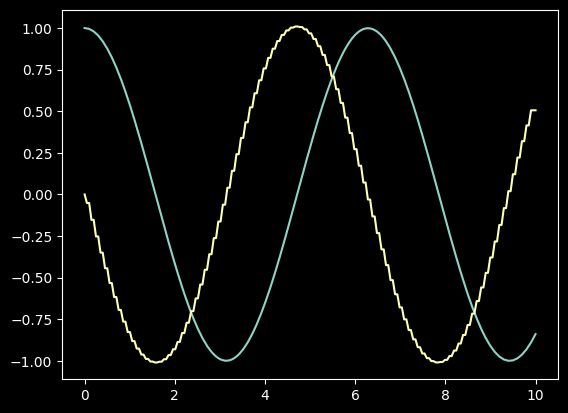

In [23]:
a = discrete_function(np.cos(np.linspace(0, 10, 100)), 10)
t = np.linspace(0, 10, 200)
plt.plot(t, [a.get_value(ti) for ti in t])
plt.plot(t, [a.get_d_dt(ti) for ti in t])
plt.show()

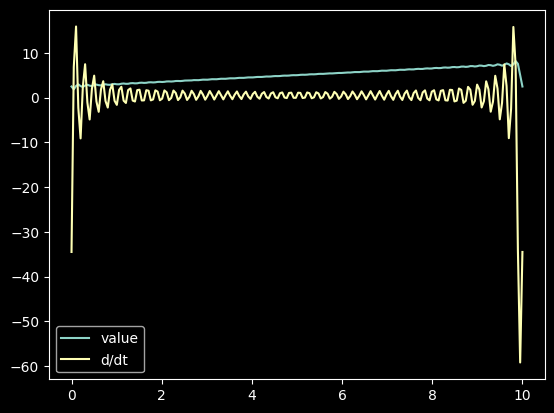

In [24]:
x = np.linspace(0, 10, 100)
time = fourier_discrete_function(x, 10)
t = np.linspace(0, 10, 200)
plt.plot(t, [time.get_value(ti) for ti in t], label='value')
plt.plot(t, [time.get_d_dt(ti) for ti in t], label='d/dt')
plt.legend()
plt.show()

In [25]:
from functools import reduce


class activity_restorer:
    def __init__(self, W, evolution, dt, index_to_restore:list[int]):
        self.itr = index_to_restore
        self.W = W
        self.evolution = [discrete_function(e, dt*len(e)) for e in evolution]
        self.timescale = dt*len(evolution[0])

    def get_gradient_MSE(self, respect_index, time):
        all_x = np.array([j.get_value(time) for j in self.evolution])
        xwx = all_x @ self.W @ all_x
        d_dx_q_dx_dt = xwx_ddx_dt_dx(all_x, self.W) # получаем градиветы для x относительно системы d/dx_q dx/dt

        gradients = dict()

        for i in range(len(self.evolution)):
            x = self.evolution[i]
            d_dx_q_delta = x.get_dd_dt_dx(respect_index, time) # получаем градиенты для функции апроксимации d/dx_q delta_X/dt
            gradients[(i, respect_index)] = (x.get_d_dt(time) - xwx[i]) * (d_dx_q_delta - d_dx_q_dx_dt[i][respect_index])
        return gradients

    def apply_gradients(self, samples, lr):
        batch_grads = dict()
        for _ in range(samples):
            time = np.random.uniform(0, self.timescale)
            batch_grads[time] = reduce((lambda a, b: a | b), (self.get_gradient_MSE(i, time) for i in self.itr), dict())
        for time in batch_grads:
            for q in self.itr:
                for i in range(len(self.evolution)):
                    ev = self.evolution[i]
                    index = round((len(ev.values) - 1) * time/ev.timescale)
                    ev.values[index] += -lr * batch_grads[time][(i, q)]
            print(batch_grads[time], 'applied')

# Testing

---
## activity generation

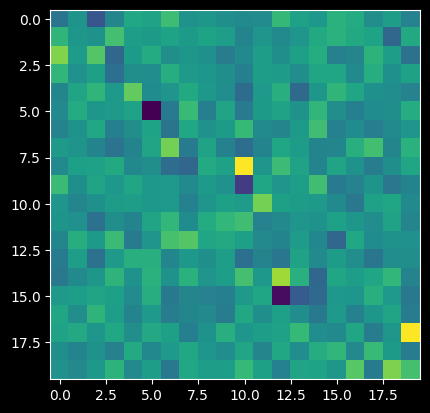

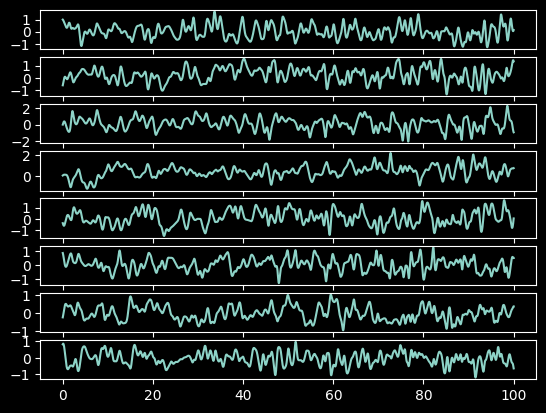

In [26]:
W = generate_connections(5, 4, group_density = 1.0, noise = 0.1, noise_density = 1.0, group_recurent_rate = 0.9)
W = generate_multiple_connections(W)
W = W - W.T
plt.imshow(W[:, :].mean(-1))
plt.show()
dt = 0.001
d = generate_activity(W, t_end= 100, dt = dt)

def plot_activity(d, var_count = 2):
    fig, ax = plt.subplots(var_count, 1)
    for n, i in enumerate(ax):
        i.plot(d['t'], d['x'][:, n])
    plt.show()

plot_activity(d, var_count = 8)

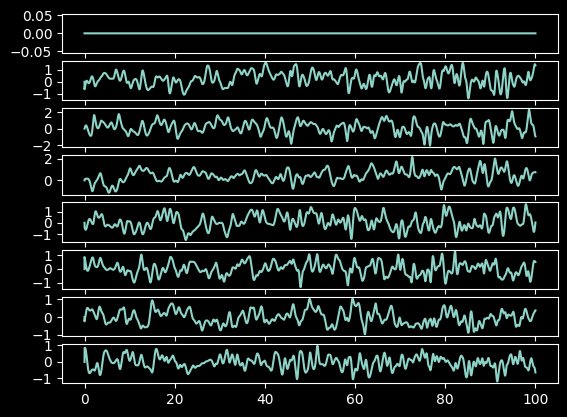

In [29]:
d['x'][:, 0] *= 0
plot_activity(d, var_count = 8)

In [30]:
ar = activity_restorer(W, d['x'], dt, [0])

In [31]:
ar.get_gradient_MSE(0, 0)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 100000)